In [323]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from cnnlearning import *
from learningutils import *
from patchextraction import *
from imageprosessing import *
from nearest_neighbors import *
from evaluation import *
from classificationutils import *
from sharedvariables import *
from vesseldetection import *
from generate_datasets import *
from plotutils import no_ticks, plot_images_as_grid
from guitools import CvRoipolySelector, CvPointSelector

import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

import os
plt.rcParams['image.cmap'] = 'gray'

# Jupyter Notebook settings

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%autosave 20
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Imports for data analysis
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 2000)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# size=25
size=10
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

report_images_folder = os.path.join(
    '..', '..', 'thesis-report', 'images', 'channel_matching'
)
pathlib.Path(report_images_folder).mkdir(exist_ok=True, parents=False)

video_sessions = get_video_sessions(marked=True, registered=True, validation=False, load_vessel_mask_from_file=True)

[vs.load_vessel_masks() for vs in video_sessions]
[vs.vessel_mask_oa790_file for vs in video_sessions], 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 20 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(['.\\data\\registered-videos\\Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped_vessel_mask.png',
  '.\\data\\registered-videos\\Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped_vessel_mask.png',
  '.\\data\\registered-videos\\Subject47_Session375_OD_(0,-1)_1.04x1.04_3056_OA790nm1_extract_reg_cropped_vessel_mask.png',
  '.\\data\\registered-videos\\Subject48_Session379_OD_(-10,0)_1.04x1.04_3111_OA790nm1_extract_reg_cropped_vessel_mask.png',
  '.\\data\\registered-videos\\Subject48_Session379_OD_(-7,-2)_1.04x1.04_3107_OA790nm1_extract_reg_cropped_vessel_mask.png',
  '.\\data\\registered-videos\\Subject52_Session404_OD_(0,-3)_1.04x1.04_3466_OA790nm1_extract_reg_cropped_vessel_mask.png',
  '.\\data\\registered-videos\\Subject52_Session404_OD_(0,-4)_1.04x1.04_3465_OA790nm1_extract_reg_cropped_vessel_mask.png',
  '.\\data\\registered-videos\\Subject52_Session408_OD_(0,-5)_1.04x1.04_3576_OA790nm1_extract_reg_cropped_vessel_mask.png'],

In [324]:
for i, vs in enumerate(video_sessions):
    print(i, vs.cell_positions[vs.validation_frame_idx].shape)

0 (81, 2)
1 (171, 2)
2 (78, 2)
3 (158, 2)
4 (143, 2)
5 (171, 2)
6 (130, 2)
7 (67, 2)


In [382]:
class TemplateMatcher(object):
    def __init__(self, im1=None, im2=None, method=cv2.TM_CCOEFF_NORMED):
        template_matching_methods = [cv2.TM_CCOEFF, cv2.TM_CCOEFF_NORMED, cv2.TM_CCORR,
                                     cv2.TM_CCORR_NORMED, cv2.TM_SQDIFF,  cv2.TM_SQDIFF_NORMED]
        assert method in template_matching_methods
        
        self.method = method
        
        self.im1 = im1
        self.im2 = im2
        
        self.cx, self.cy = None, None
        self.dx, self.dy = None, None
        self.correlation_image = None
        self.image = None
        
        return
    
    def match(self):
        h, w = self.im1.shape
        centre_row, centre_col = int(h / 2), int(w / 2)
        template = self.im1[centre_row - 11:centre_row + 11,
                            centre_col - 11:centre_col + 11]
        self.template = template
        
        template = np.float32(self.template)
        
        image = np.float32(self.im2)
        im_h, im_w = image.shape
        template_h, template_w = template.shape
        
        correlation_image = cv2.matchTemplate(image, template, self.method)
        self.correlation_image = correlation_image
        
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(correlation_image)
        
        # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
        if self.method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc

        self.cx, self.cy  = (np.floor(top_left[0] + template_w / 2), np.floor(top_left[1] + template_h / 2))
        self.dx, self.dy = self.cx - (im_w - 1) / 2, self.cy - (im_h - 1) /2
        
        return self.cx, self.cy
    
    def visualize_matching(self, figsize=(15, 10), savename='', s=155,fontsize=20, linewidth=4.3):
        import matplotlib.patches
        from plotutils import savefig_tight
        
        im_h, im_w = self.im1.shape
        mid_x, mid_y = int((im_w - 1) / 2), int((im_h - 1) /2) 
        
        # template image
        plt.figure(figsize=figsize)
        plt.imshow(self.template)
        no_ticks()
        
        
        # image 1 with template square at middle
        plt.figure(figsize=figsize)
        plt.imshow(self.im1)
        if savename:
            savefig_tight(f'{savename}_template.png')
            
        rect = matplotlib.patches.Rectangle((mid_x - 11, mid_y -11) , 21, 21, linewidth=7.5, edgecolor='r', facecolor='none')
        ax = plt.gca()
        ax.add_patch(rect)
        no_ticks()
        if savename:
            savefig_tight(f'{savename}_im1.png')
            
        plt.figure(figsize=figsize)
        no_ticks()
        # image 2 with displacement
        plt.imshow(self.im2)
        plt.scatter(mid_x, mid_y)
        assert [mid_x + self.dx, mid_y + self.dy] == [self.cx, self.cy]
        plt.scatter(self.cx, self.cy, s=s)

        plt.plot([mid_x,    self.cx],         [mid_y,    self.cy], 'b', linestyle='--', linewidth=linewidth, marker='', label='displacment')
        plt.plot([mid_x,    mid_x + self.dx], [mid_y,    mid_y],   'r', linestyle='--', linewidth=linewidth, marker='', label='dx')
        plt.plot([mid_x + self.dx,    mid_x + self.dx],           [mid_y,    mid_y + self.dy], 'y', linewidth=linewidth, linestyle='--', marker='', label='dy')
        plt.legend(prop={'size': fontsize})
        if savename:
            savefig_tight(f'{savename}_im2.png')
        
class FeatureMatcher(object):
    def __init__(self, im1, im2):
        self.im1 = im1
        self.im2 = im2
        
        im1_x, im1_y = None, None
        im2_x, im2_y = None, None
        self.dx, self.dy = None, None

    def match(self):
        im1 = self.im1
        im2 = self.im2
        
        for i in range(400, 0, -10):
            # Initiate feature detector
            surf = cv2.xfeatures2d.SURF_create(i)

            # find the keypoints and descriptors with surf
            kp1, des1 = surf.detectAndCompute(im1, None)
            kp2, des2 = surf.detectAndCompute(im2, None)

            if des1 is None or des2 is None or len(kp1) is 0 or len(kp2) is 0:
                continue

            # create BFMatcher object
            bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
            # Match descriptors.
            matches = bf.match(des1, des2)

            if len(matches) is 0:
                continue
            # Sort them in the order of their distance.
            matches = sorted(matches, key = lambda x:x.distance)
            # Draw first match
            match = matches[0]
            img1_idx = match.queryIdx
            img2_idx = match.trainIdx

            self.kp1 = kp1
            self.kp2 = kp2
            self.matches = matches
            
            # x - columns
            # y - rows
            # Get the coordinates
            self.im1_x, self.im1_y = kp1[img1_idx].pt
            self.im2_x, self.im2_y = kp2[img2_idx].pt
            
            self.dx, self.dy = self.im2_x -  self.im1_x, self.im2_y - self.im1_y
            return self.im2_x, self.im2_y
        
    def visualize_matching(self, figsize=(15, 10), linewidth=2.3, savefile=''):
        from plotutils import savefig_tight
        
        plt.figure(figsize=figsize)
        plt.subplot(121)
        plt.imshow(self.im1)
        no_ticks()
        plt.scatter(self.im1_x, self.im1_y)
        ax1 = plt.gca()
        
        plt.subplot(122)
        plt.imshow(self.im2)
        no_ticks()
        plt.scatter(self.im2_x, self.im2_y)
        ax2 = plt.gca()

        coordsA = "data"
        coordsB = "data"
        con = matplotlib.patches.ConnectionPatch(xyA=(self.im1_x, self.im1_y), xyB=(self.im2_x, self.im2_y), color='g',
                                                 coordsA=coordsA, coordsB=coordsB, mutation_scale=15, linewidth=3.5,
                                                 axesA=ax1, axesB=ax2, arrowstyle="->", shrinkB=5, shrinkA=5)
        ax2.add_artist(con)

        
        mid_x = self.im1_x
        mid_y = self.im1_y
        plt.plot([mid_x,    self.im2_x],         [mid_y,    self.im2_y], 'b', linestyle='--', linewidth=linewidth, marker='', label='displacment')
        plt.plot([mid_x,    mid_x + self.dx], [mid_y,    mid_y],   'r', linestyle='--', linewidth=linewidth, marker='', label='dx')
        plt.plot([mid_x + self.dx,    mid_x + self.dx],           [mid_y,    mid_y + self.dy], 'y', linewidth=linewidth, linestyle='--', marker='', label='dy')
        plt.legend()

        if savefile:
            savefig_tight(f'{savefile}_feature_matching.png')
        

def create_average_images(video_session, frame_idx=0, patch_size=51, sigma=1, average_all_frames=True, savefile=''):
    from skimage.exposure import equalize_adapthist
    from imageprosessing import equalize_adapt_hist_masked
    from skimage.filters import gaussian
    vs = video_session
    vs.load_vessel_masks()
    vs.visualize_registration()

    #### #### #### #### #### #### #### #### #### #### 
    window = 'select segment'
    from plotutils import savefig_tight
    
    # cv2.imshow(window, frame_OA790)
    registered_frame_oa850_clone = vs.registered_frames_oa850[frame_idx].copy()
    registered_frame_oa850_clone = registered_frame_oa850_clone[..., np.newaxis]
    registered_frame_oa850_clone = np.concatenate((registered_frame_oa850_clone, registered_frame_oa850_clone, registered_frame_oa850_clone), axis=-1)
    
    frame_oa790 = vs.frames_oa790[frame_idx]
    
    all_cell_positions = np.empty((0, 2), dtype=np.int32)
    for frame_idx, cell_positions in vs.cell_positions.items():
        all_cell_positions = np.concatenate((all_cell_positions, cell_positions), axis=0)
    
    for x, y in vs.cell_positions[frame_idx]:
        registered_frame_oa850_clone = cv2.circle(registered_frame_oa850_clone, (x, y), 1, (255, 0, 0))

    roipoly_selector = CvRoipolySelector(window, registered_frame_oa850_clone)
    roipoly_selector.activate()

    plt.rcParams['image.cmap'] = 'gray'
    plt.rcParams['axes.titlesize'] = 30
    plt.rcParams['figure.titlesize'] = 30
    
    plt.figure(figsize=(30, 20))
    plt.imshow(roipoly_selector.modified_image)
    if savefile:
        savefig_tight(f'{savefile}_selection.png')
    
    selected_vessel_mask = roipoly_selector.mask.copy() 
    plt.figure(figsize=(30, 20))
    plt.subplot(121)
    plt.imshow(frame_oa790 * selected_vessel_mask * vs.registered_mask_frames_oa850[frame_idx])
    no_ticks()
    plt.subplot(122)
    plt.imshow(vs.registered_frames_oa850[frame_idx] * selected_vessel_mask * vs.registered_mask_frames_oa850[frame_idx])
    no_ticks()
    if savefile:
        savefig_tight(f'{savefile}_selected_segment.png')
    
    frame_oa790 = vs.frames_oa790[frame_idx]
    registered_frame_oa850 = vs.registered_frames_oa850[frame_idx]
    
    frame_cell_positions = vs.cell_positions[frame_idx]
    frame_cell_positions = np.delete(frame_cell_positions, np.where(~selected_vessel_mask[frame_cell_positions[:, 1], frame_cell_positions[:, 0]])[0], axis=0)

    cell_patches_oa790 = extract_patches_at_positions(frame_oa790,            frame_cell_positions, mask=selected_vessel_mask, patch_size=patch_size)
    cell_patches_oa850 = extract_patches_at_positions(registered_frame_oa850, frame_cell_positions, mask=selected_vessel_mask, patch_size=patch_size)

    cell_patches_oa790 = cell_patches_oa790 / 255
    cell_patches_oa850 = cell_patches_oa850 / 255
    for i, (cell_patch_oa790, cell_patch_oa850) in enumerate(zip(cell_patches_oa790, cell_patches_oa850)):
        cell_patches_oa790[i] = gaussian(cell_patch_oa790, sigma)
        cell_patches_oa850[i] = gaussian(cell_patch_oa850, sigma)
        
    cell_patches_oa790 = np.uint8(cell_patches_oa790 * 255)
    cell_patches_oa850 = np.uint8(cell_patches_oa850 * 255)
    
    return cell_patches_oa790, cell_patches_oa850

(12.866825103759766,
 14.519430160522461,
 19.400232999555232,
 38.899986267089844,
 38.591312408447266,
 '..\\..\\thesis-report\\images\\channel_matching\\Subject52_Session404_OD_(0,-3)_1.04x1_feature_matching.png')

<Figure size 1440x576 with 0 Axes>

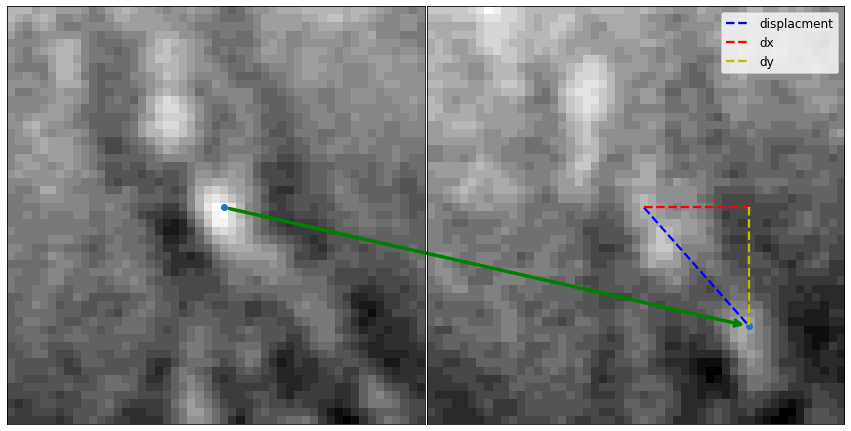

In [392]:
feature_matcher = FeatureMatcher(np.uint8(np.round(avg_cell_oa790)), np.uint8(np.round(avg_cell_oa850)))
feature_matcher.match()

plt.subplots_adjust(wspace=0.005, hspace=2)
feature_matcher.visualize_matching()
plt.savefig(os.path.join(report_images_folder, f'{os.path.splitext(vs.basename)[0]}_feature_matching.png'))
plt.subplots_adjust(wspace=0.005, hspace=2)

feature_matcher.dx, feature_matcher.dy, np.sqrt(feature_matcher.dx**2 + feature_matcher.dy**2), feature_matcher.im2_x, feature_matcher.im2_y, os.path.join(report_images_folder, f'{os.path.splitext(vs.basename)[0]}_feature_matching.png')

(520, 520)
86


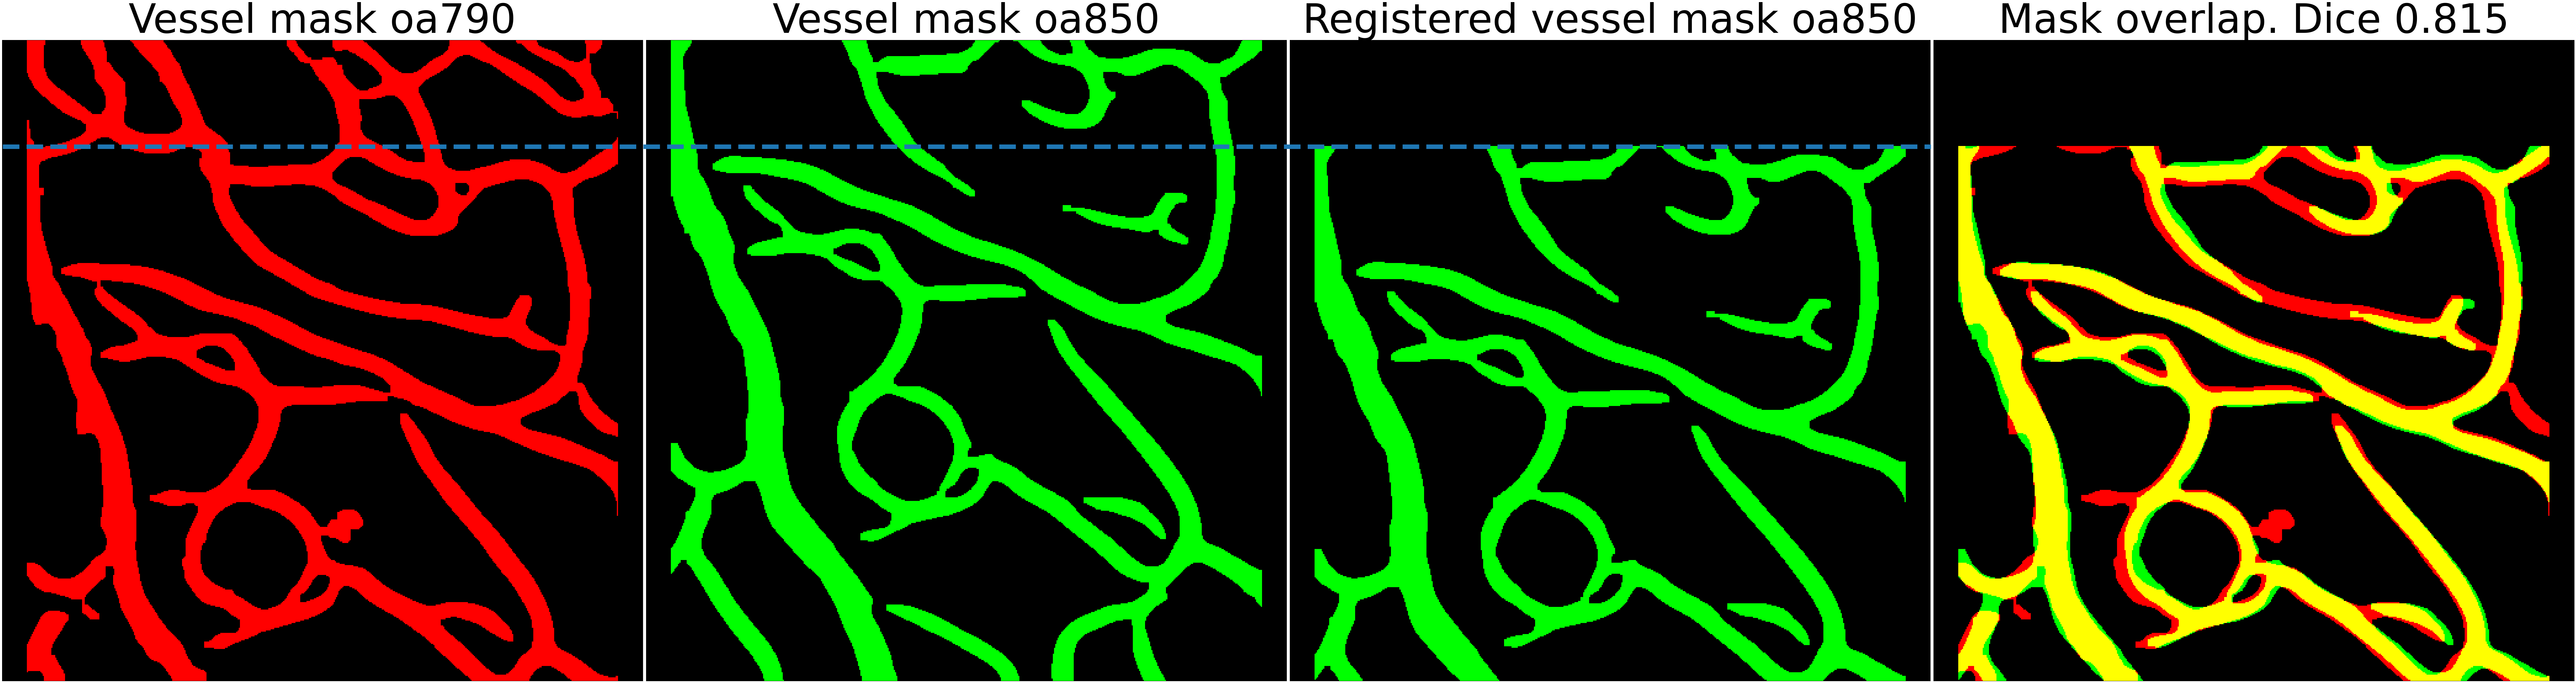

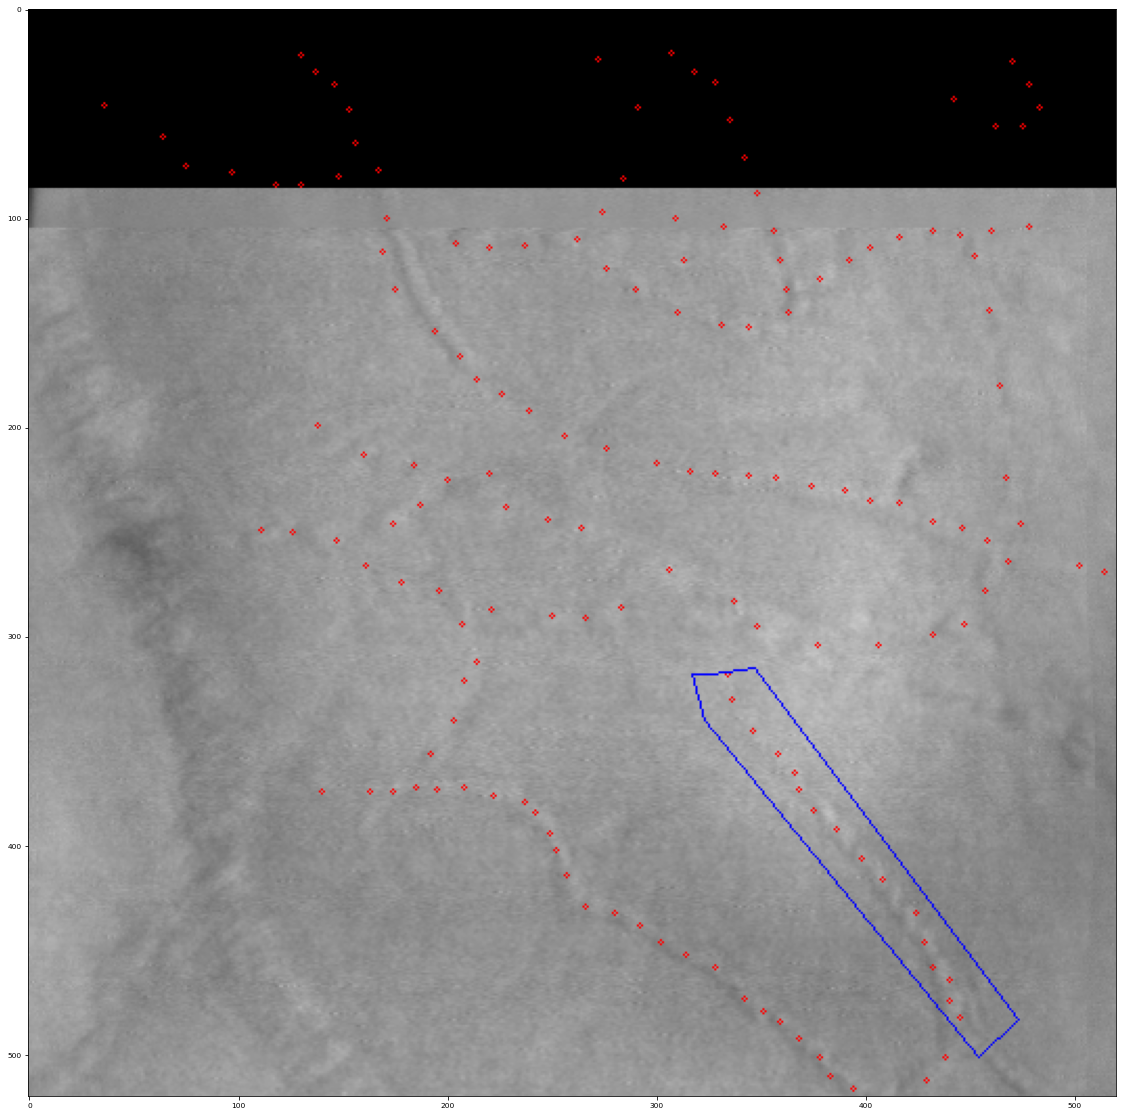

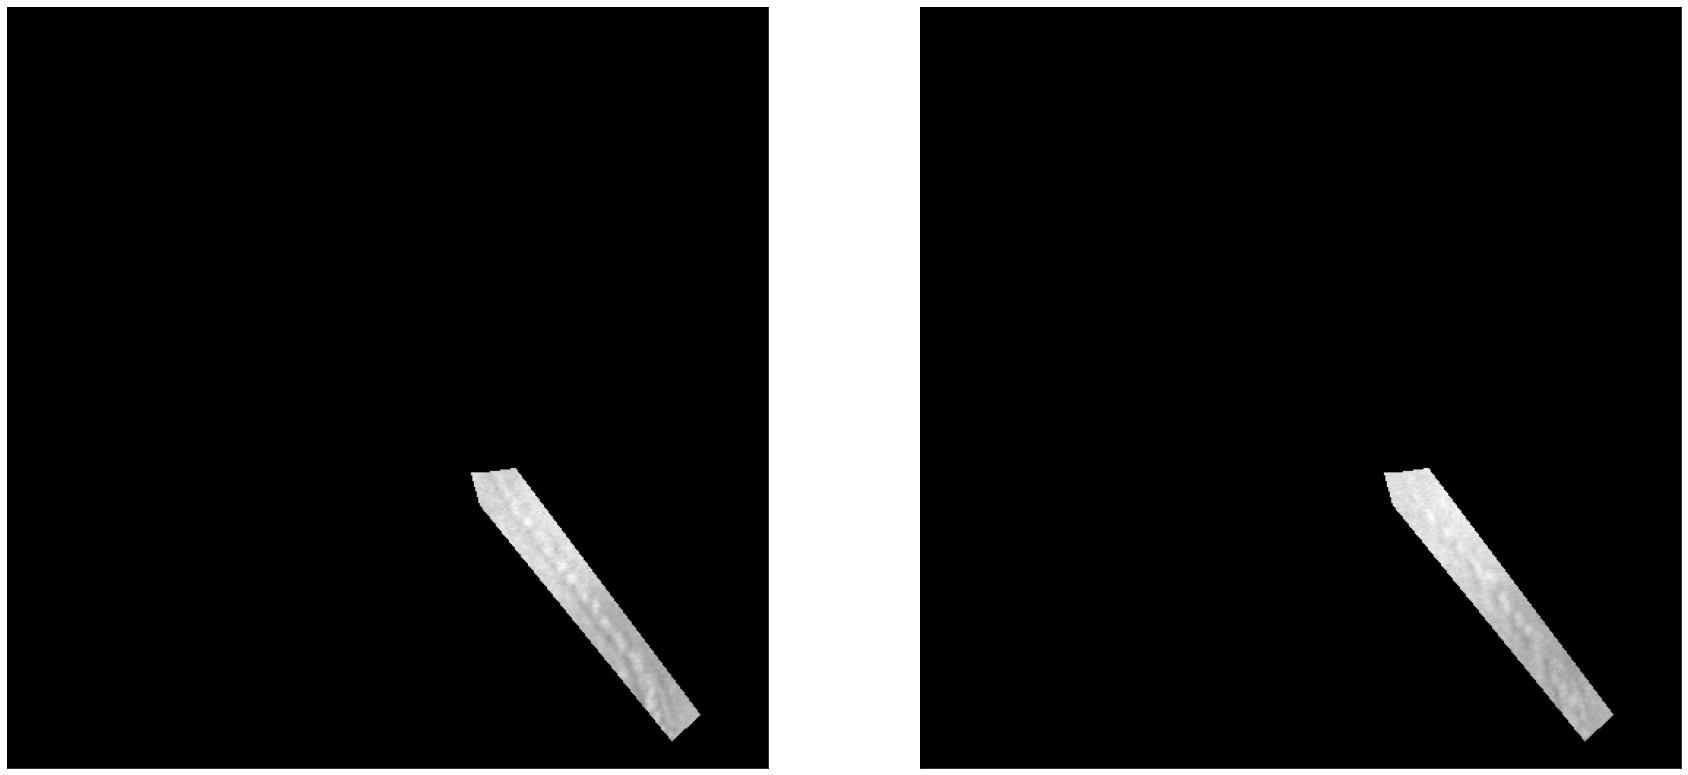

In [339]:
vs = video_sessions[5]
vs.cell_positions[vs.validation_frame_idx]
cell_patches_oa790, cell_patches_oa850 =\
create_average_images(vs, vs.validation_frame_idx, patch_size=51, sigma=0.5, average_all_frames=False)#, savefile=os.path.join(report_images_folder, os.path.splitext(vs.basename)[0]))

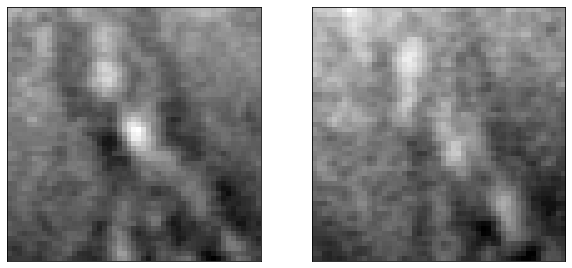

In [326]:
from skimage.filters import gaussian
from skimage.exposure import match_histograms
avg_cell_oa790 = np.average(cell_patches_oa790, axis=0)
avg_cell_oa850 = np.average(cell_patches_oa850, axis=0)

s=.0
avg_cell_oa790 = avg_cell_oa790
# avg_cell_oa850 = match_histograms(avg_cell_oa850, avg_cell_oa790)

avg_cell_oa790 = gaussian(avg_cell_oa790, sigma=s)
avg_cell_oa850 = gaussian(avg_cell_oa850, sigma=s)

## ## ###
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(avg_cell_oa790)
no_ticks()
plt.subplot(122)
plt.imshow(avg_cell_oa850)
no_ticks()

(12.0, 15.0, 19.209372712298546, 37.0, 40.0)

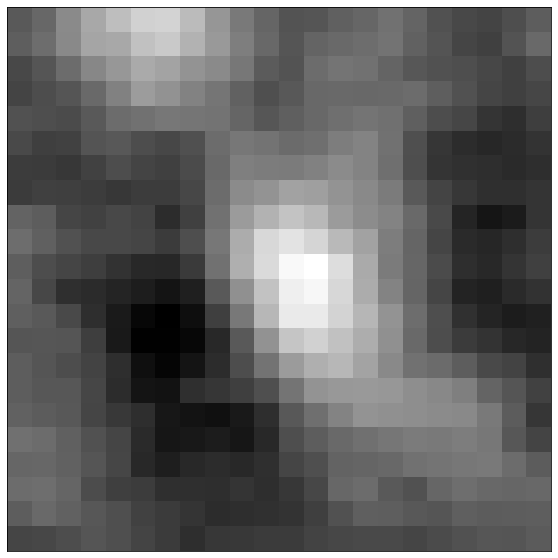

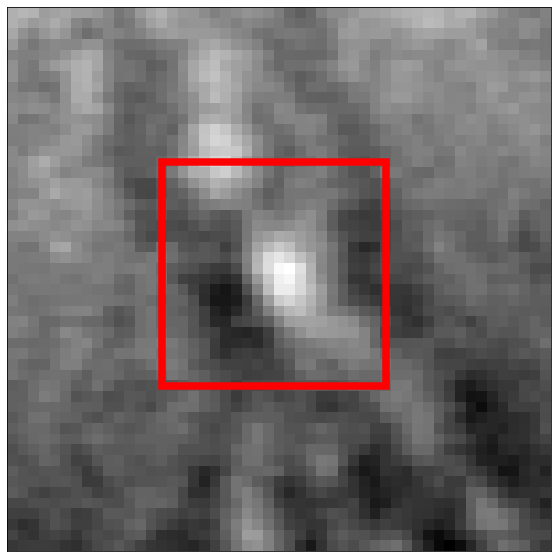

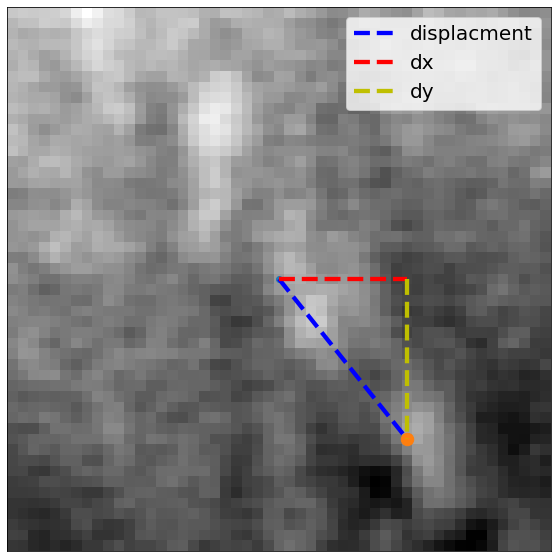

In [327]:
template_matcher = TemplateMatcher()
template_matcher.im1 = avg_cell_oa790
template_matcher.im2 = avg_cell_oa850
template_matcher.match()
template_matcher.visualize_matching()#savename=os.path.join(report_images_folder, f'{os.path.splitext(vs.basename)[0]}_avg_cell'))
template_matcher.dx, template_matcher.dy, np.sqrt(template_matcher.dx**2 + template_matcher.dy**2), template_matcher.cx, template_matcher.cy

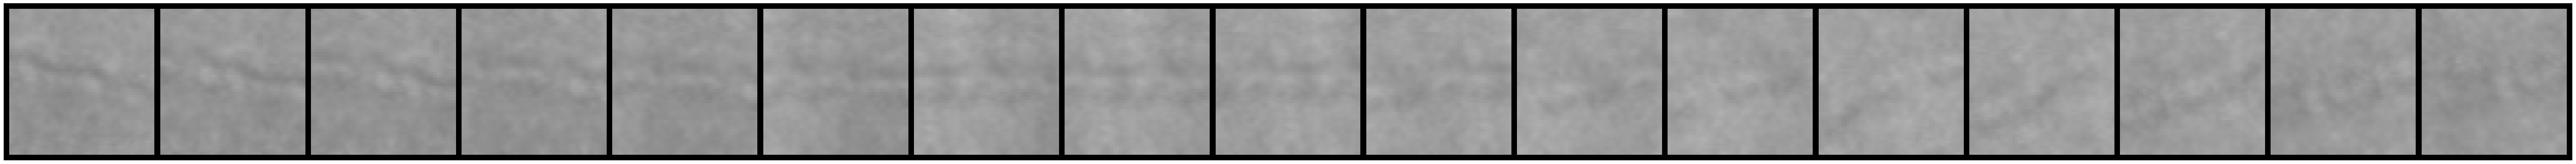

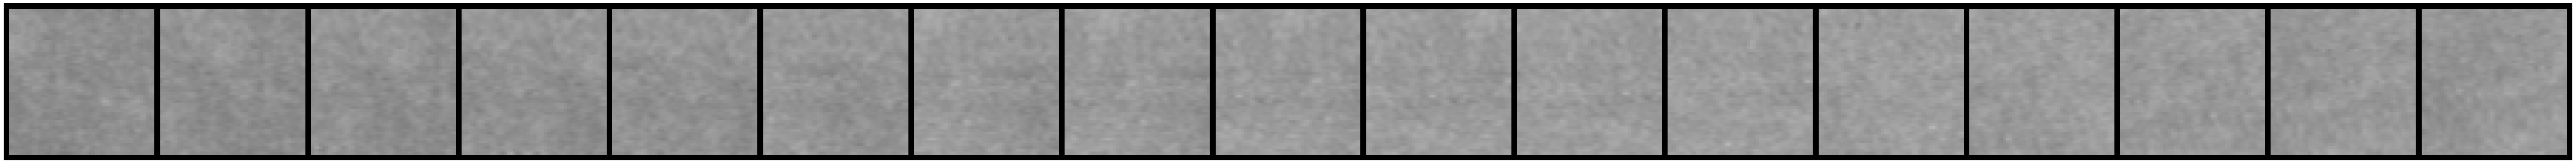

In [298]:
from plotutils import savefig_tight
plot_images_as_grid(cell_patches_oa790.astype(np.uint8))
savefig_tight(os.path.join(report_images_folder, f'{os.path.splitext(vs.basename)[0]}_cell_patches_oa790.png'))
plot_images_as_grid(cell_patches_oa850.astype(np.uint8))
savefig_tight(os.path.join(report_images_folder, f'{os.path.splitext(vs.basename)[0]}_cell_patches_oa850.png'))        

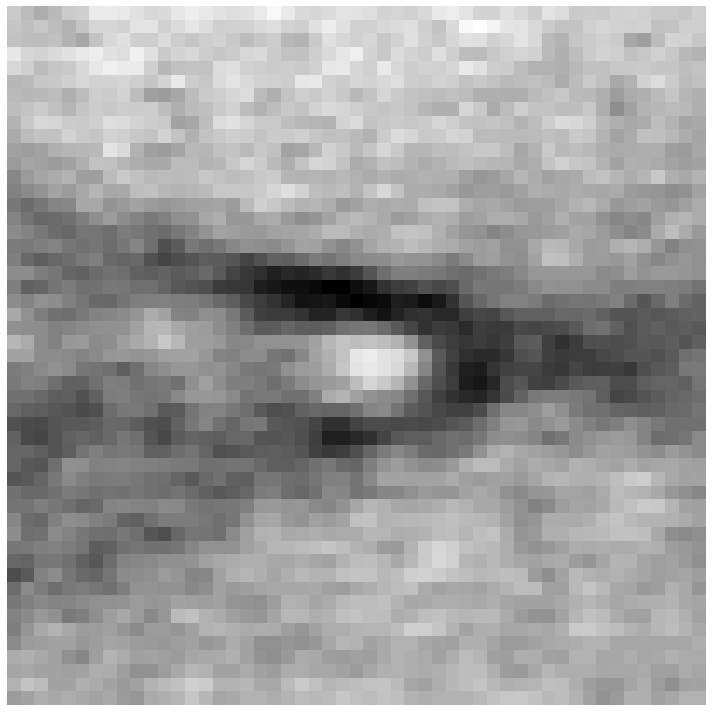

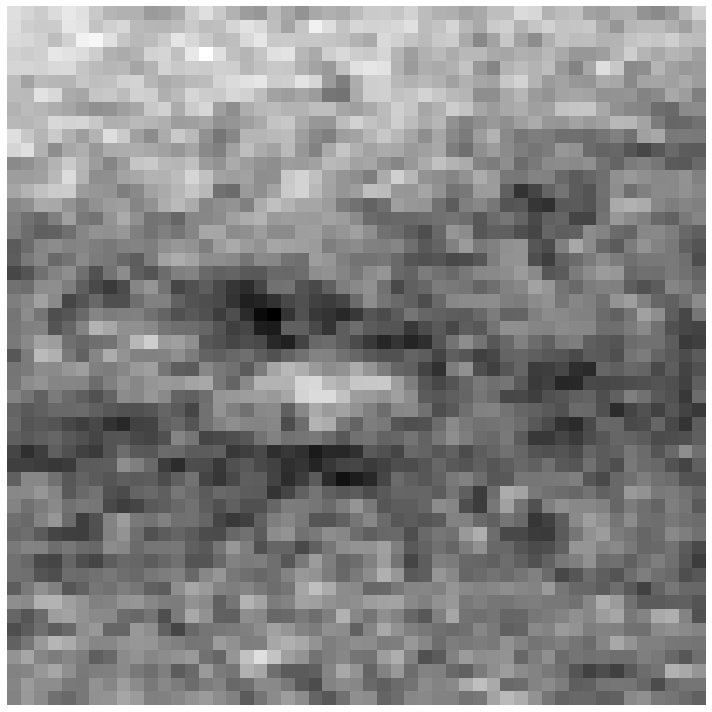

In [223]:
plt.figure(figsize=(10, 10))
plt.imshow(avg_cell_oa790)
no_ticks()
savefig_tight(os.path.join(report_images_folder, f'{os.path.splitext(vs.basename)[0]}_avg_cell_oa790.png'))

plt.figure(figsize=(10, 10))
plt.imshow(avg_cell_oa850)
no_ticks()
savefig_tight(os.path.join(report_images_folder, f'{os.path.splitext(vs.basename)[0]}_avg_cell_oa850.png'))

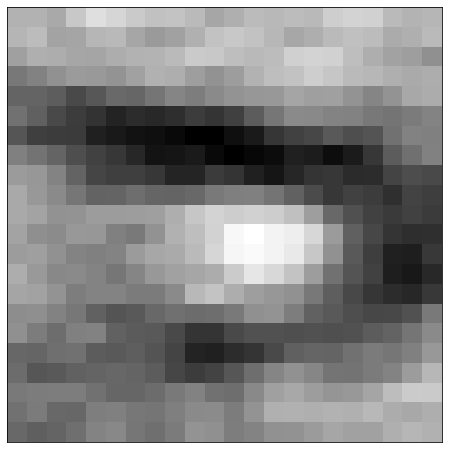

In [224]:
# The template is cropped from the middle of the average cell oa790 
template_matcher = TemplateMatcher(avg_cell_oa790, avg_cell_oa850)
template_matcher.match()
plt.imshow(template_matcher.template)
no_ticks()

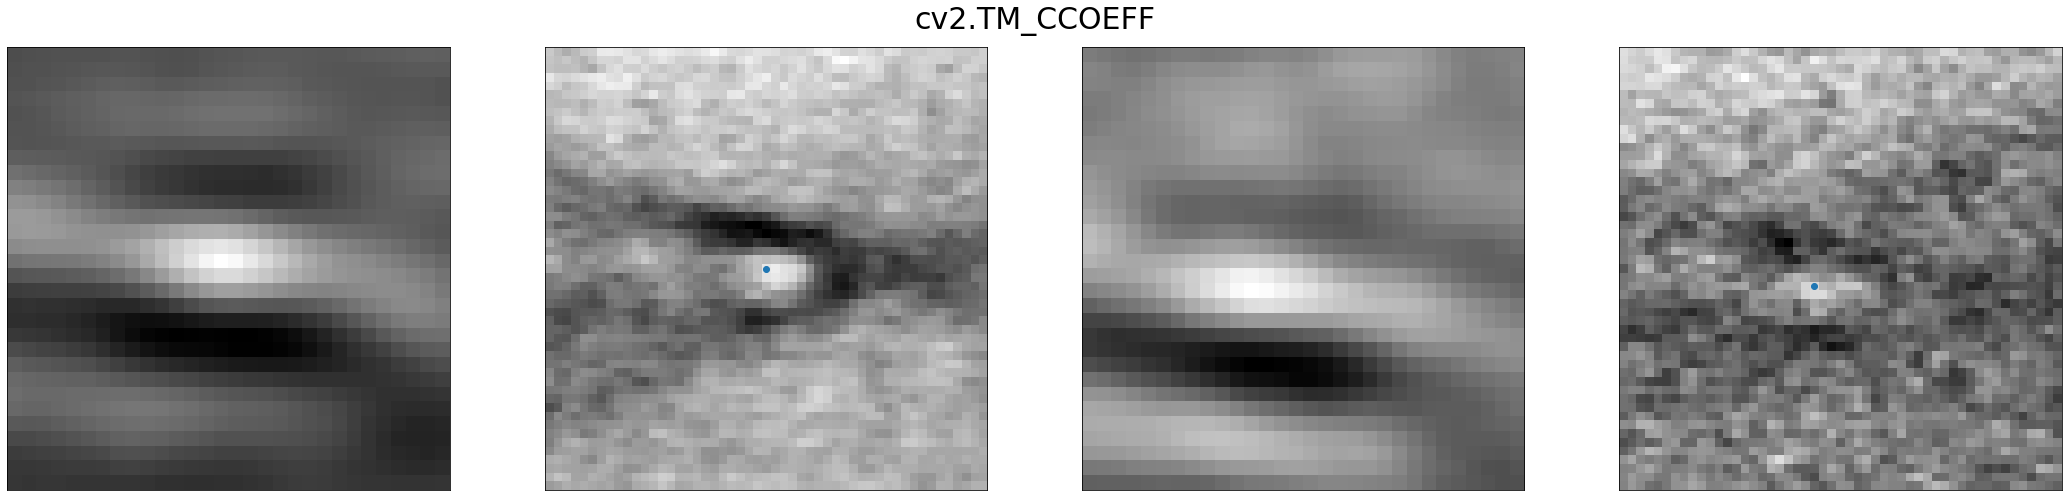

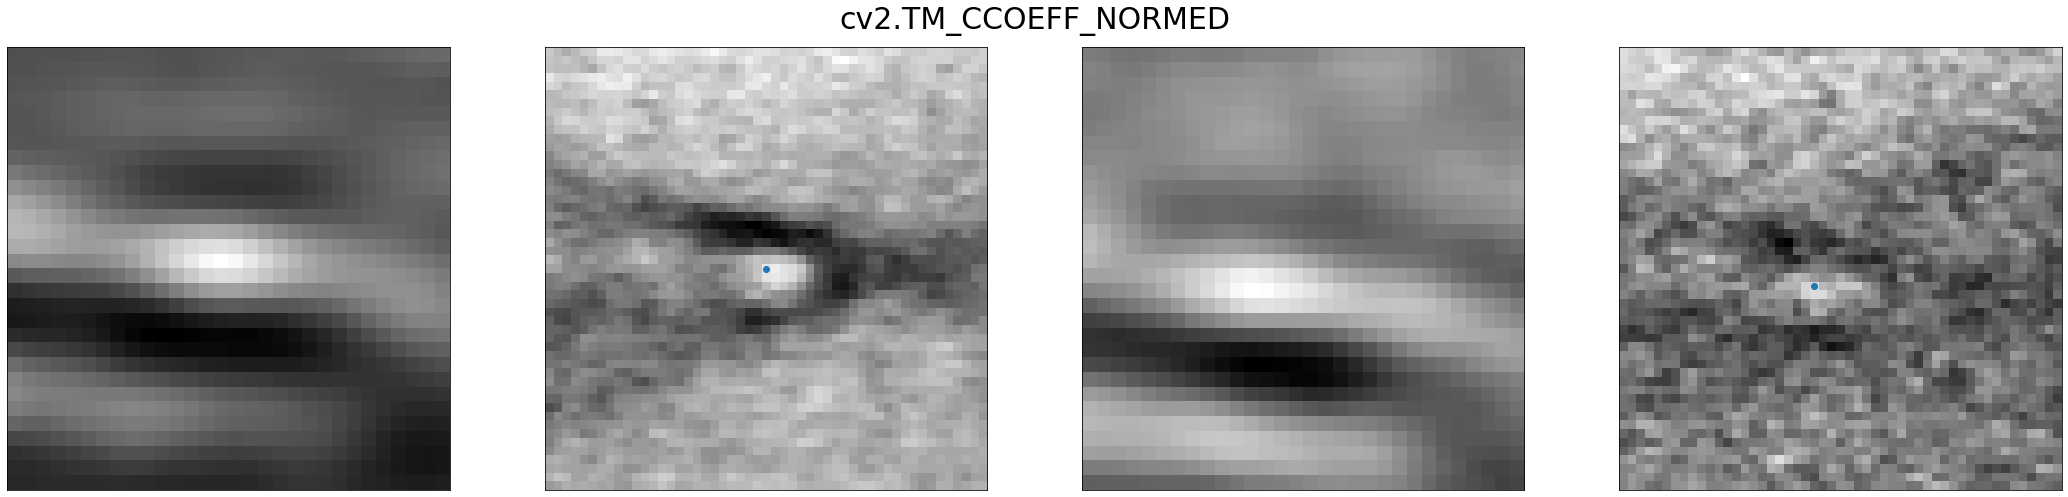

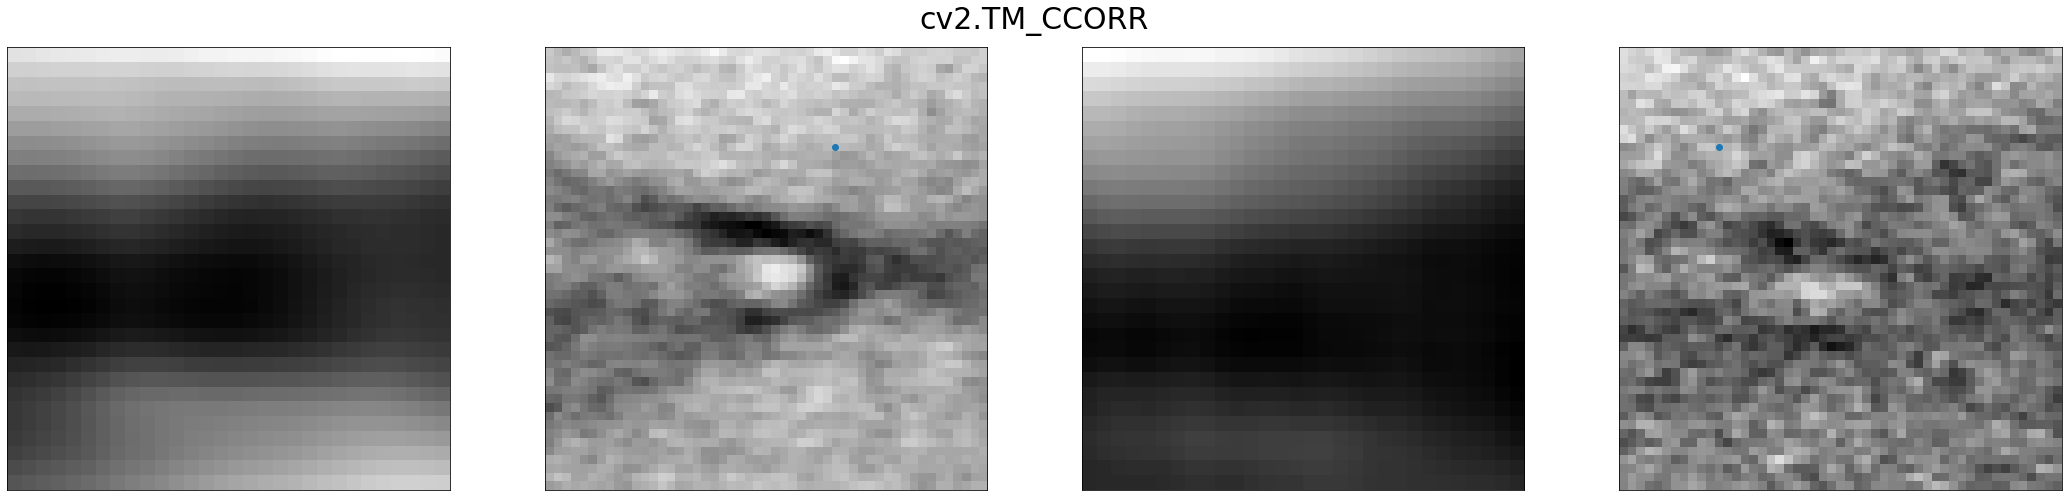

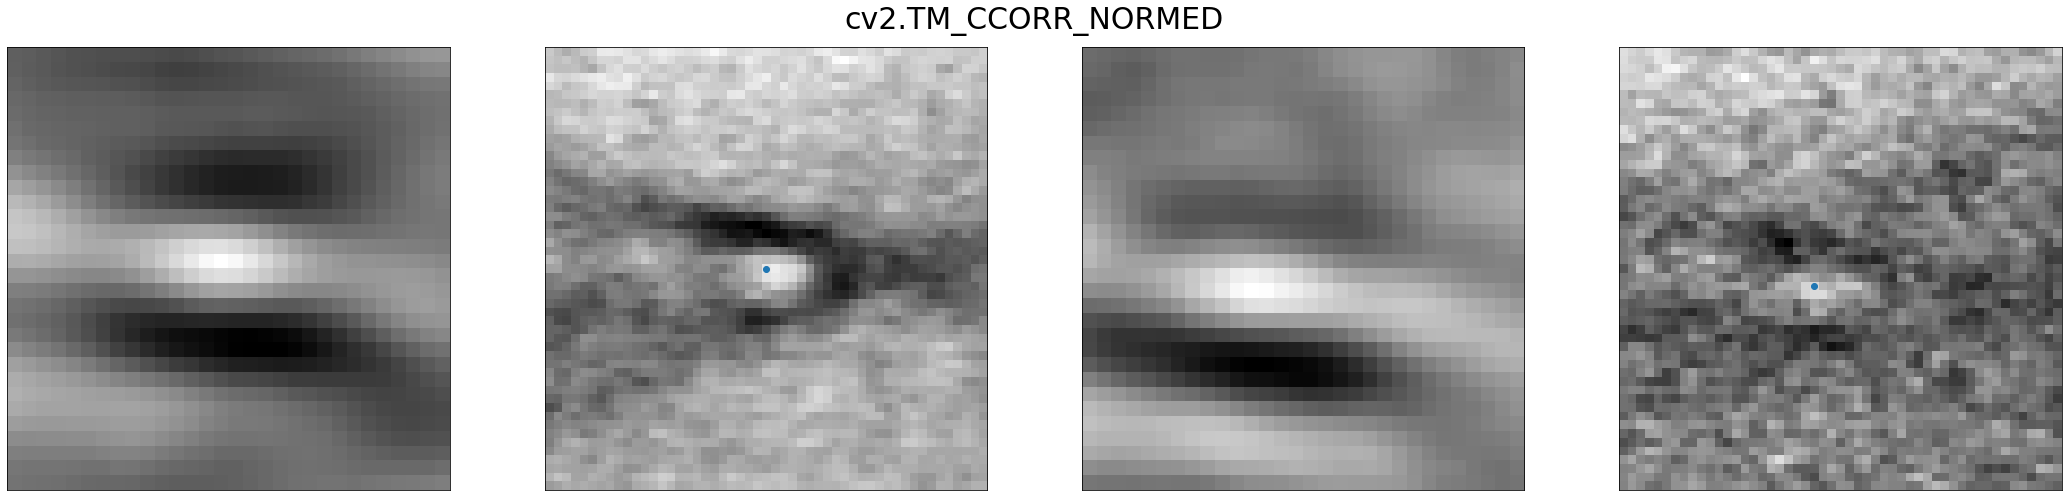

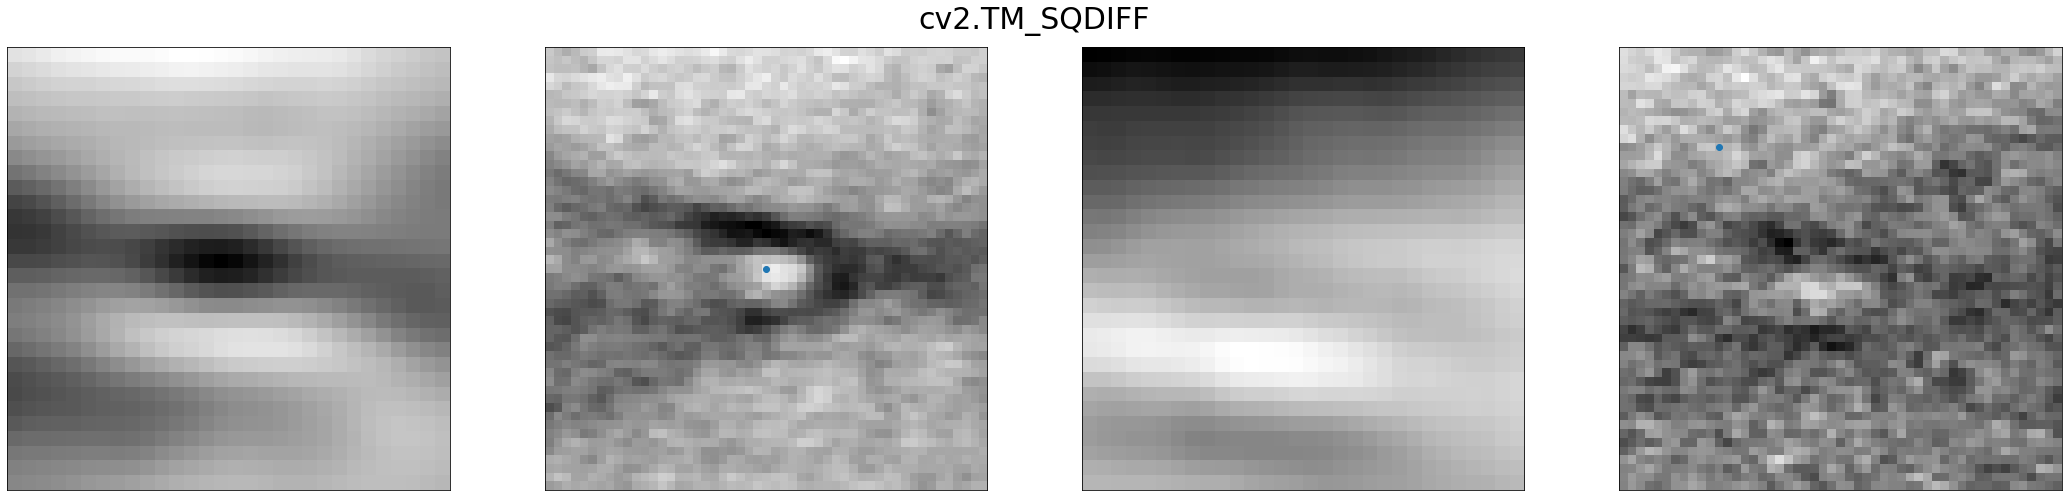

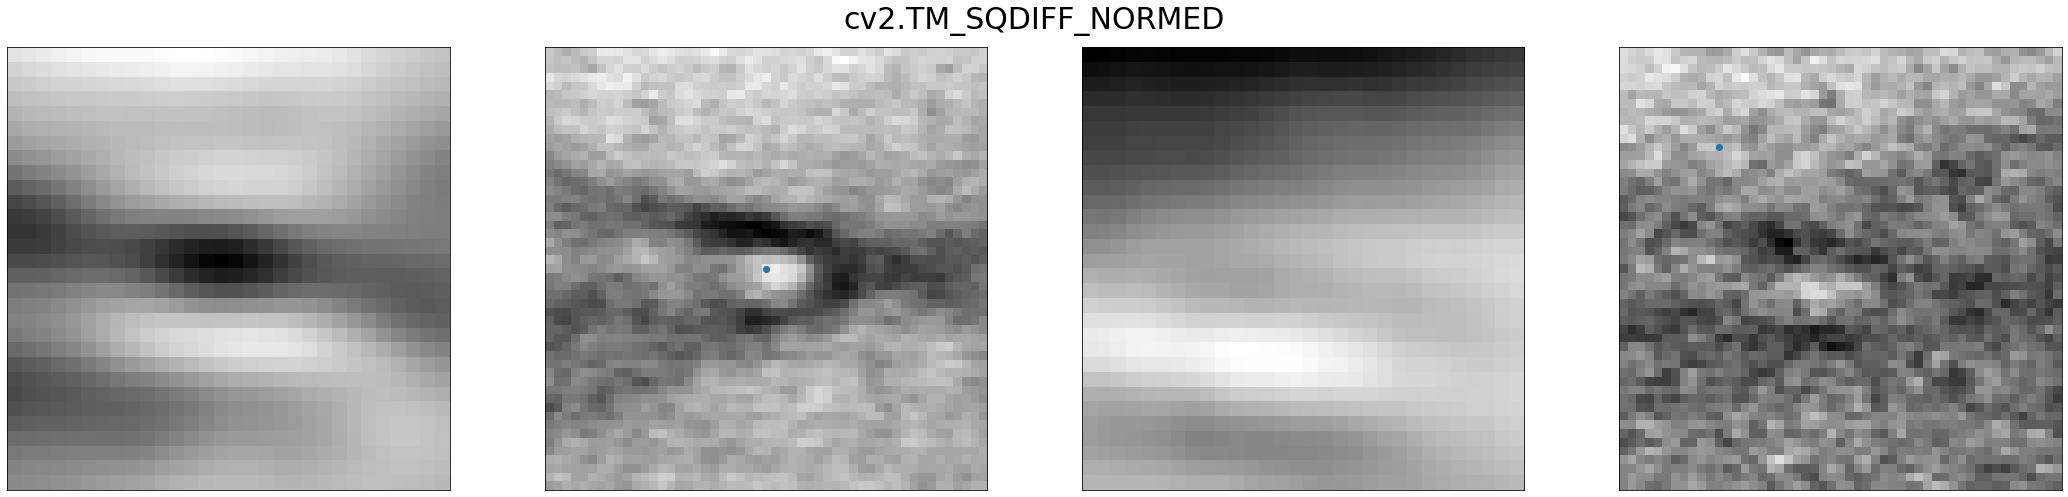

In [225]:
template_matching_methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR', 'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
template_matcher = TemplateMatcher()
for method in template_matching_methods:
    template_matcher.method = eval(method)
    template_matcher.im1 = avg_cell_oa790
    template_matcher.im2 = avg_cell_oa790
    
    cx790, cy790 = template_matcher.match()
    correlation_image_790 = template_matcher.correlation_image
    
    template_matcher.im2 = avg_cell_oa850
    cx850, cy850 = template_matcher.match()
    correlation_image_850 = template_matcher.correlation_image

    ## plots ##
    plt.figure(figsize=(30, 7))
    plt.suptitle(method)
    plt.subplot(141)
    plt.imshow(correlation_image_790)
    no_ticks()

    plt.subplot(142)
    plt.imshow(avg_cell_oa790)
    plt.scatter(cx790, cy790)
    no_ticks()

    plt.subplot(143)
    plt.imshow(correlation_image_850)
    no_ticks()

    plt.subplot(144)
    plt.imshow(avg_cell_oa850)
    plt.scatter(cx850, cy850)
    no_ticks()
    plt.tight_layout()

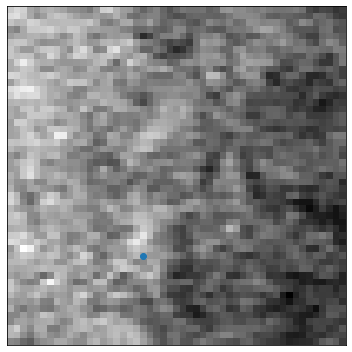

In [97]:
cx, cy = feature_matching(np.uint8(np.round(avg_cell_oa790)), np.uint8(np.round(avg_cell_oa850)))

## plots ##
plt.figure(figsize=(10,5))
plt.imshow(avg_cell_oa850)
plt.scatter(cx, cy)
no_ticks()

plt.tight_layout()

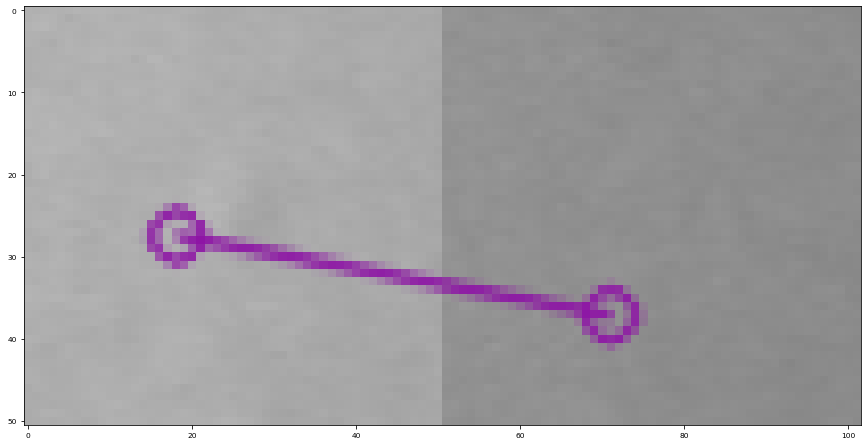

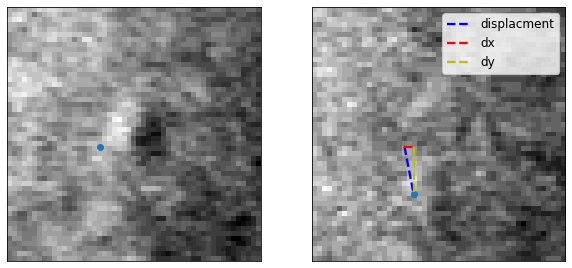

In [74]:
feature_matcher = FeatureMatcher(np.uint8(np.round(avg_cell_oa790)), np.uint8(np.round(avg_cell_oa850)))
feature_matcher.match()
feature_matcher.visualize_matching()

In [81]:
cell_patches_oa790.shape, cell_patches_oa850.shape

((7, 51, 51), (7, 51, 51))

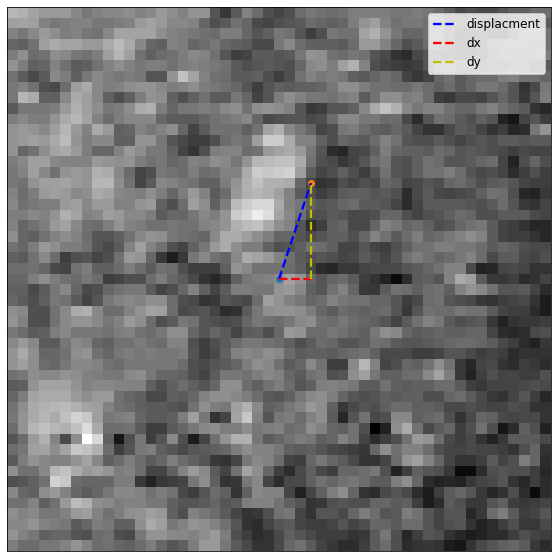

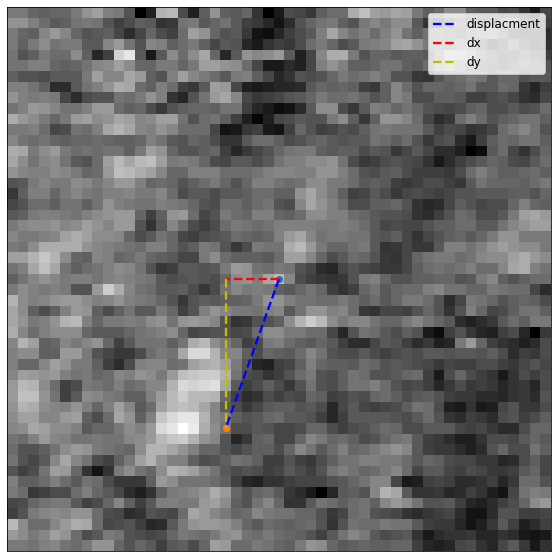

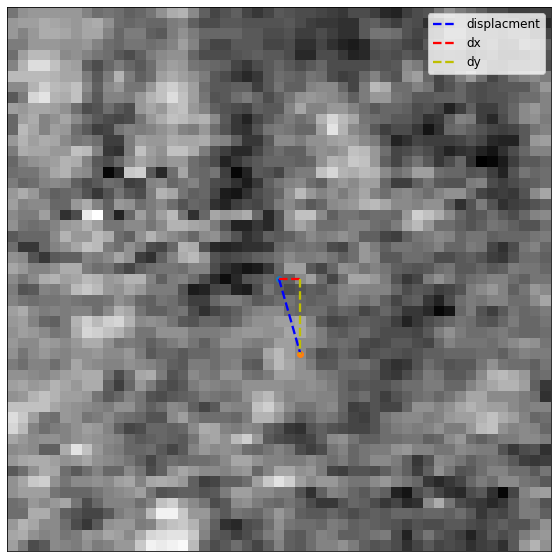

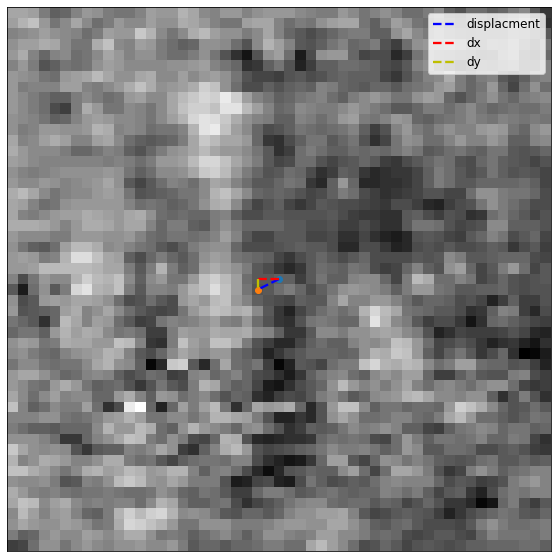

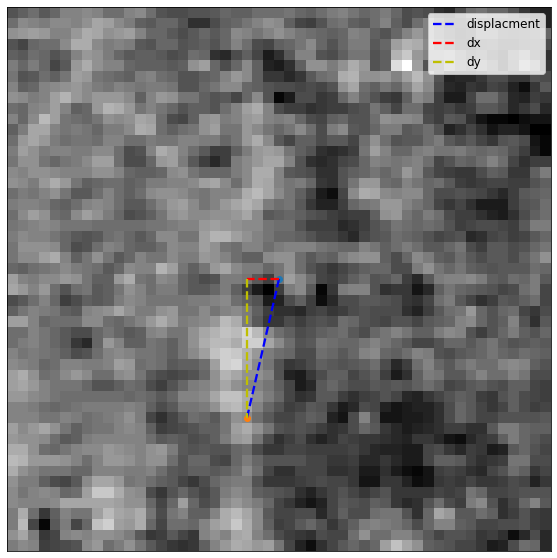

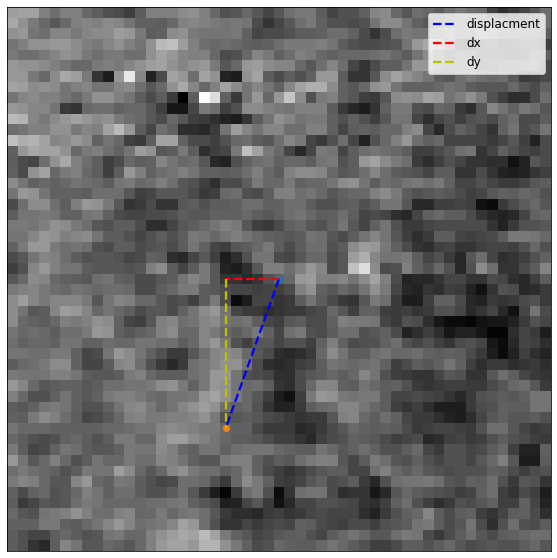

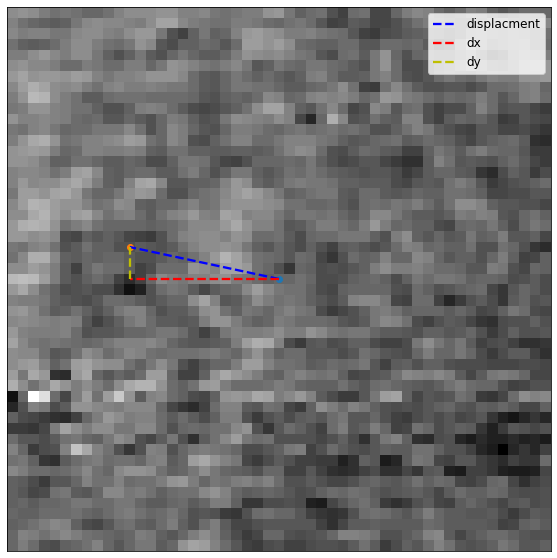

In [90]:
template_matcher = TemplateMatcher()
xs, ys = [], []
for patch_oa790, patch_oa850 in zip(cell_patches_oa790, cell_patches_oa850):
    # The template is cropped from the middle of the average cell oa790 
    h, w = avg_cell_oa790.shape
    centre_row, centre_col = int(h / 2), int(w / 2)
    template_cell = patch_oa790[centre_row - 11:centre_row + 11,
                                centre_col - 11:centre_col + 11]
    template_matcher.template = template_cell
    
    x, y = template_matcher.match(patch_oa850)
    template_matcher.visualize_matching()
    xs.append(x)
    ys.append(y)

In [93]:
np.mean(xs), np.mean(ys), 23.0, 38

(21.571428571428573, 30.285714285714285, 23.0, 38)

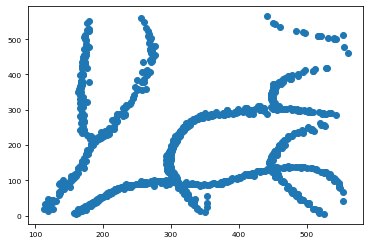

In [7]:
all_cell_positions = np.zeros((0, 2), dtype=np.int32)
for frame_idx, cell_positions in vs.cell_positions.items():
    all_cell_positions = np.concatenate((all_cell_positions, cell_positions), axis=0)

plt.scatter(all_cell_positions[:, 0], all_cell_positions[:, 1])

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model, datasets


n_samples = 1000
n_outliers = 50


X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=10,
                                      coef=True, random_state=0)

# Add outlier data
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(coef, lr.coef_, ransac.estimator_.coef_)

lw = 2
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

In [ ]:
X.shape

In [ ]:
from sklearn import linear_model
x = points[:, 0, np.newaxis]
y = points[:, 1, np.newaxis]

# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(x, y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(x, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_x = np.arange(x.min(), x.max())[:, np.newaxis]
line_y = lr.predict(line_x)
line_y_ransac = ransac.predict(line_x)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(coef, lr.coef_, ransac.estimator_.coef_)

lw = 2
plt.scatter(x[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(x[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_x, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_x, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

In [ ]:
def sequential_RANSAC(points):
    """
    points Nx2
    """
    lines_x = []
    lines_y = []
    
    inlier_masks = []
    outlier_masks = []

    x = points[:, 0, np.newaxis]
    y = points[:, 1, np.newaxis]
    prev_size = len(x)
    while len(x) >= 2 :
        # Fit line using all data
        lr = linear_model.LinearRegression()
        lr.fit(x, y)

        # Robustly fit linear model with RANSAC algorithm
        ransac = linear_model.RANSACRegressor()
        ransac.fit(x, y)
        inlier_mask = ransac.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)

        # Predict data of estimated models
        line_x = np.arange(x.min(), x.max())[:, np.newaxis]
        line_y_ransac = ransac.predict(line_x)

        lines_x.append(line_x)
        lines_y.append(line_y_ransac)
        
        inlier_masks.append(inlier_mask)
        outlier_masks.append(outlier_mask)
        
        x = x[outlier_mask]
        y = y[outlier_mask]

        prev_size = len(x)

    return lines_x, lines_y, inlier_masks, outlier_masks

In [ ]:
# Cluster points
from sklearn.cluster import KMeans

X = points
kmeans = KMeans(n_clusters=2, random_state=0).fit(points)
y_km = kmeans.fit_predict(X)

# plot the 3 clusters
plt.scatter(
    X[y_km == 0, 0], X[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X[y_km == 1, 0], X[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    X[y_km == 2, 0], X[y_km == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

# plot the centroids
plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [ ]:
# Cluster points
from sklearn.cluster import KMeans, MeanShift

ks = np.arange(4, 12)
_, axes = plt.subplots(len(ks), figsize=(5, 30))
for ax, k in zip(axes, ks):
    X = points
    clustering = KMeans(k).fit(points)
    cluster_labeling = clustering.fit_predict(X)

    colors = np.random.rand(90, ).reshape(30, 3)

    for label_color, cluster_label in zip(colors, np.unique(cluster_labeling)):
        cur_points = X[cluster_labeling == cluster_label] 
        ax.scatter(
            X[cluster_labeling == cluster_label, 0], X[cluster_labeling == cluster_label, 1],
            s=50, c=[label_color],
            marker='s', edgecolor='black',
        )
        lines_x, lines_y, inlier_masks, outlier_masks = sequential_RANSAC(cur_points)    
        
        for line_x, line_y in zip(lines_x, lines_y):
            ax.plot(line_x, line_y)
            
    ax.grid()

In [ ]:
import cv2
import numpy as np

img = np.uint8(skeleton_lee)
img = np.concatenate((img[..., np.newaxis], 
                      img[..., np.newaxis], 
                      img[..., np.newaxis]), axis=-1)
min_line_length = 10
max_line_gap = 10
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, min_line_length, max_line_gap)
for x1,y1,x2,y2 in lines[0]:
    img = cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

plt.imshow(img)

In [ ]:
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert

# Invert the horse image
image = vs.vessel_mask_confocal.copy()
image = skimage.morphology.binary_erosion(image)
image = skimage.morphology.binary_erosion(image)
image = skimage.morphology.binary_erosion(image)

# perform skeletonization
skeleton = skeletonize(image)

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
plt.show()

In [ ]:
from skimage.morphology import medial_axis, skeletonize

# Invert the horse image
image = vs.vessel_mask_confocal.copy()
image = skimage.morphology.binary_erosion(image)
image = skimage.morphology.binary_erosion(image)
blobs = skimage.morphology.binary_erosion(image)

# Compute the medial axis (skeleton) and the distance transform
skel, distance = medial_axis(blobs, return_distance=True)

# Compare with other skeletonization algorithms
skeleton = skeletonize(blobs)
skeleton_lee = skeletonize(blobs, method='lee')

# Distance to the background for pixels of the skeleton
dist_on_skel = distance * skel

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(blobs, cmap=plt.cm.gray)
ax[0].set_title('original')
ax[0].axis('off')

ax[1].imshow(dist_on_skel, cmap='magma')
ax[1].contour(blobs, [0.5], colors='w')
ax[1].set_title('medial_axis')
ax[1].axis('off')

ax[2].imshow(skeleton, cmap=plt.cm.gray)
ax[2].set_title('skeletonize')
ax[2].axis('off')

ax[3].imshow(skeleton_lee, cmap=plt.cm.gray)
ax[3].set_title("skeletonize (Lee 94)")
ax[3].axis('off')

fig.tight_layout()
plt.show()

In [ ]:
edges = edges * 255

In [ ]:
edges = cv2.Canny(np.uint8(edges_clone) * 255,0,255,apertureSize = 5)
plt.imshow(cv2.Canny(np.uint8(edges_clone) * 255,0,255,apertureSize = 5))

In [ ]:
edges_clone = edges.copy()
edges_clone = skimage.morphology.binary_erosion(edges_clone)
edges_clone = skimage.morphology.binary_erosion(edges_clone)
edges_clone = skimage.morphology.binary_erosion(edges_clone)
edges_clone = skimage.morphology.binary_erosion(edges_clone)
edges_clone = skimage.morphology.binary_erosion(edges_clone)
edges_clone = skimage.morphology.binary_erosion(edges_clone)
edges_clone = skimage.morphology.binary_erosion(edges_clone)
edges_clone = skimage.morphology.binary_erosion(edges_clone)
edges_clone = skimage.morphology.binary_erosion(edges_clone)

plt.imshow(skimage.morphology.binary_erosion(edges_clone))

In [ ]:
edges.dtype